## 1. SETUP & CONFIGURATION

In [2]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from typing import Tuple, Dict, List
import warnings
import urllib.request
warnings.filterwarnings('ignore')

# Download BRISQUE model files if not present
MODEL_DIR = Path("../models/brisque")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_FILE = MODEL_DIR / "brisque_model_live.yml"
RANGE_FILE = MODEL_DIR / "brisque_range_live.yml"

BRISQUE_MODEL_URL = "https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/quality/samples/brisque_model_live.yml"
BRISQUE_RANGE_URL = "https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/quality/samples/brisque_range_live.yml"

def download_brisque_models():
    """Download BRISQUE model files from OpenCV repository."""
    if not MODEL_FILE.exists():
        print(f"Downloading BRISQUE model file...")
        urllib.request.urlretrieve(BRISQUE_MODEL_URL, MODEL_FILE)
        print(f"✓ Downloaded: {MODEL_FILE}")
    
    if not RANGE_FILE.exists():
        print(f"Downloading BRISQUE range file...")
        urllib.request.urlretrieve(BRISQUE_RANGE_URL, RANGE_FILE)
        print(f"✓ Downloaded: {RANGE_FILE}")
    
    print("✓ BRISQUE model files ready")

# Download models
download_brisque_models()

# Check if OpenCV BRISQUE quality module is available
try:
    # This requires opencv-contrib-python
    test_brisque = cv2.quality.QualityBRISQUE_create(str(MODEL_FILE), str(RANGE_FILE))
    BRISQUE_AVAILABLE = True
    print("✓ OpenCV BRISQUE quality module detected")
    del test_brisque
except AttributeError:
    print("⚠️  OpenCV BRISQUE not available.")
    print("   opencv-contrib-python is required.")
    print("   Run: uv remove opencv-python && uv add opencv-contrib-python")
    BRISQUE_AVAILABLE = False
except Exception as e:
    print(f"⚠️  Error initializing BRISQUE: {e}")
    BRISQUE_AVAILABLE = False

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

✓ Downloaded: ..\models\brisque\brisque_model_live.yml
✓ Downloaded: ..\models\brisque\brisque_range_live.yml
✓ BRISQUE model files ready
✓ OpenCV BRISQUE quality module detected


In [3]:
# ========== CONFIGURATION ==========
# Paths
ROI_DIR = Path("../data/interim/processed_rois")
OUTPUT_DIR = Path("../data/interim")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# BRISQUE Parameters (Based on technical spec)
# BRISQUE score range: 0-100 (0 = perfect, 100 = worst)
BRISQUE_THRESHOLD = 80.0  # Scores > 80 indicate poor quality
QUALITY_THRESHOLD = 0.2  # Minimum Q_N to pass (from spec)
# Note: Q_N = 1.0 - M_N/100, so Q_N < 0.2 means M_N > 80

# Visualization
SAMPLE_SIZE = 10
RANDOM_SEED = 42

## 2. CORE FUNCTIONS

In [4]:
def calculate_naturalness_metric(image: np.ndarray, brisque_obj) -> float:
    """
    Calculate naturalness metric using OpenCV BRISQUE algorithm.

    Args:
        image: Input image (BGR format from cv2.imread)
        brisque_obj: Initialized cv2.quality.QualityBRISQUE object

    Returns:
        BRISQUE score (M_N) in range [0, 100+]
        Lower scores = better quality (more natural)
        Higher scores = worse quality (noise/artifacts)

    Theory:
        BRISQUE analyzes Natural Scene Statistics (NSS):
        - Mean Subtracted Contrast Normalized (MSCN) coefficients
        - Generalized Gaussian Distribution (GGD) modeling
        - Asymmetric Generalized Gaussian Distribution (AGGD) for pairwise products
        Distorted images deviate from natural statistics patterns.
    """
    # OpenCV BRISQUE works on grayscale images
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Calculate BRISQUE score using OpenCV quality module
    # compute() returns a tuple: (score, )
    score = brisque_obj.compute(gray)[0]

    return score


def naturalness_quality_inverted(metric: float) -> float:
    """
    Map BRISQUE metric to quality score using inverted linear mapping.

    Args:
        metric: BRISQUE score (M_N)

    Returns:
        Quality score Q_N in range [0.0, 1.0]

    Formula:
        Q_N = 1.0 - M_N / 100
        If M_N > 100, Q_N = 0.0
    """
    if metric > 100:
        return 0.0

    quality = 1.0 - (metric / 100.0)
    return max(0.0, quality)  # Ensure non-negative


def analyze_naturalness(image_path: Path, brisque_obj) -> Dict[str, float]:
    """
    Analyze naturalness for a single image.

    Args:
        image_path: Path to the image file
        brisque_obj: Initialized cv2.quality.QualityBRISQUE object

    Returns:
        Dictionary containing:
            - 'metric': BRISQUE score (M_N)
            - 'quality': Quality score (Q_N)
            - 'pass': Boolean indicating if image passes threshold
    """
    # Read image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Calculate metric
    metric = calculate_naturalness_metric(image, brisque_obj)

    # Calculate quality score
    quality = naturalness_quality_inverted(metric)

    return {"metric": metric, "quality": quality, "pass": quality >= QUALITY_THRESHOLD}

## 3. INITIALIZE BRISQUE MODEL

In [5]:
if not BRISQUE_AVAILABLE:
    print("ERROR: OpenCV BRISQUE not available.")
    print("Please install opencv-contrib-python:")
    print("  uv remove opencv-python")
    print("  uv add opencv-contrib-python")
    print("Then restart the kernel.")
else:
    print("Initializing OpenCV BRISQUE model...")
    # Create BRISQUE object with pre-trained model files
    brisque = cv2.quality.QualityBRISQUE_create(str(MODEL_FILE), str(RANGE_FILE))
    print("✓ OpenCV BRISQUE model loaded successfully")

Initializing OpenCV BRISQUE model...
✓ OpenCV BRISQUE model loaded successfully


## 4. BATCH PROCESSING

In [6]:
def process_all_images(roi_dir: Path, brisque_obj) -> pd.DataFrame:
    """
    Process all images in the ROI directory.

    Args:
        roi_dir: Directory containing ROI images
        brisque_obj: Initialized cv2.quality.QualityBRISQUE object

    Returns:
        DataFrame with analysis results
    """
    results = []
    image_files = sorted(roi_dir.glob("*.jpg")) + sorted(roi_dir.glob("*.png"))

    print(f"Processing {len(image_files)} images...")
    print(
        "⚠️  Note: BRISQUE analysis is computationally intensive. This may take a while."
    )

    for i, img_path in enumerate(image_files, 1):
        try:
            result = analyze_naturalness(img_path, brisque_obj)
            results.append(
                {
                    "filename": img_path.name,
                    "brisque_score": result["metric"],
                    "quality_score": result["quality"],
                    "status": "PASS" if result["pass"] else "REJECT",
                }
            )

            if i % 50 == 0:
                print(f"  Processed: {i}/{len(image_files)}")

        except Exception as e:
            print(f"  Error processing {img_path.name}: {e}")
            continue

    df = pd.DataFrame(results)
    print(f"\n✓ Complete: {len(df)} images analyzed")
    return df

In [7]:
if BRISQUE_AVAILABLE:
    # Run batch processing
    df_results = process_all_images(ROI_DIR, brisque)
    display(df_results.head(10))
else:
    print("Skipping batch processing - BRISQUE not available")

Processing 706 images...
⚠️  Note: BRISQUE analysis is computationally intensive. This may take a while.
  Processed: 50/706
  Processed: 100/706
  Processed: 150/706
  Processed: 200/706
  Processed: 250/706
  Processed: 300/706
  Processed: 350/706
  Processed: 400/706
  Processed: 450/706
  Processed: 500/706
  Processed: 550/706
  Processed: 600/706
  Processed: 650/706
  Processed: 700/706

✓ Complete: 706 images analyzed


,filename,brisque_score,quality_score,status
0,0000065.jpg,20.007957,0.799920,PASS
1,0000088.jpg,10.855393,0.891446,PASS
2,0000089.jpg,31.933346,0.680667,PASS
3,0000155.jpg,19.074236,0.809258,PASS
4,0000160.jpg,16.158421,0.838416,PASS
5,0000164.jpg,17.003048,0.829970,PASS
6,0000186.jpg,27.328999,0.726710,PASS
7,0000204.jpg,22.117292,0.778827,PASS
8,0000267.jpg,35.338333,0.646617,PASS
9,0000287.jpg,26.552801,0.734472,PASS


## 5. STATISTICAL ANALYSIS

In [8]:
if BRISQUE_AVAILABLE:
    # Overall statistics
    print("=" * 60)
    print("NATURALNESS ANALYSIS SUMMARY (BRISQUE)")
    print("=" * 60)
    print(f"Total Images: {len(df_results)}")
    print(f"\nStatus Distribution:")
    print(df_results["status"].value_counts())
    print(
        f"\nPass Rate: {(df_results['status'] == 'PASS').sum() / len(df_results) * 100:.2f}%"
    )
    print("\n" + "-" * 60)
    print("BRISQUE Score (M_N) Statistics:")
    print("  (Lower is better - 0 is perfect, 100+ is very poor)")
    print(df_results["brisque_score"].describe())
    print("\n" + "-" * 60)
    print("Quality Score (Q_N) Statistics:")
    print("  (Higher is better - 1.0 is perfect, 0.0 is very poor)")
    print(df_results["quality_score"].describe())
    print("=" * 60)
else:
    print("Skipping statistical analysis - BRISQUE not available")

NATURALNESS ANALYSIS SUMMARY (BRISQUE)
Total Images: 706

Status Distribution:
status
PASS    706
Name: count, dtype: int64

Pass Rate: 100.00%

------------------------------------------------------------
BRISQUE Score (M_N) Statistics:
  (Lower is better - 0 is perfect, 100+ is very poor)
count    706.000000
mean      23.804563
std        9.998130
min        1.691854
25%       16.305518
50%       23.188429
75%       30.640998
max       59.330738
Name: brisque_score, dtype: float64

------------------------------------------------------------
Quality Score (Q_N) Statistics:
  (Higher is better - 1.0 is perfect, 0.0 is very poor)
count    706.000000
mean       0.761954
std        0.099981
min        0.406693
25%        0.693590
50%        0.768116
75%        0.836945
max        0.983081
Name: quality_score, dtype: float64


## 6. VISUALIZATION: METRIC DISTRIBUTION

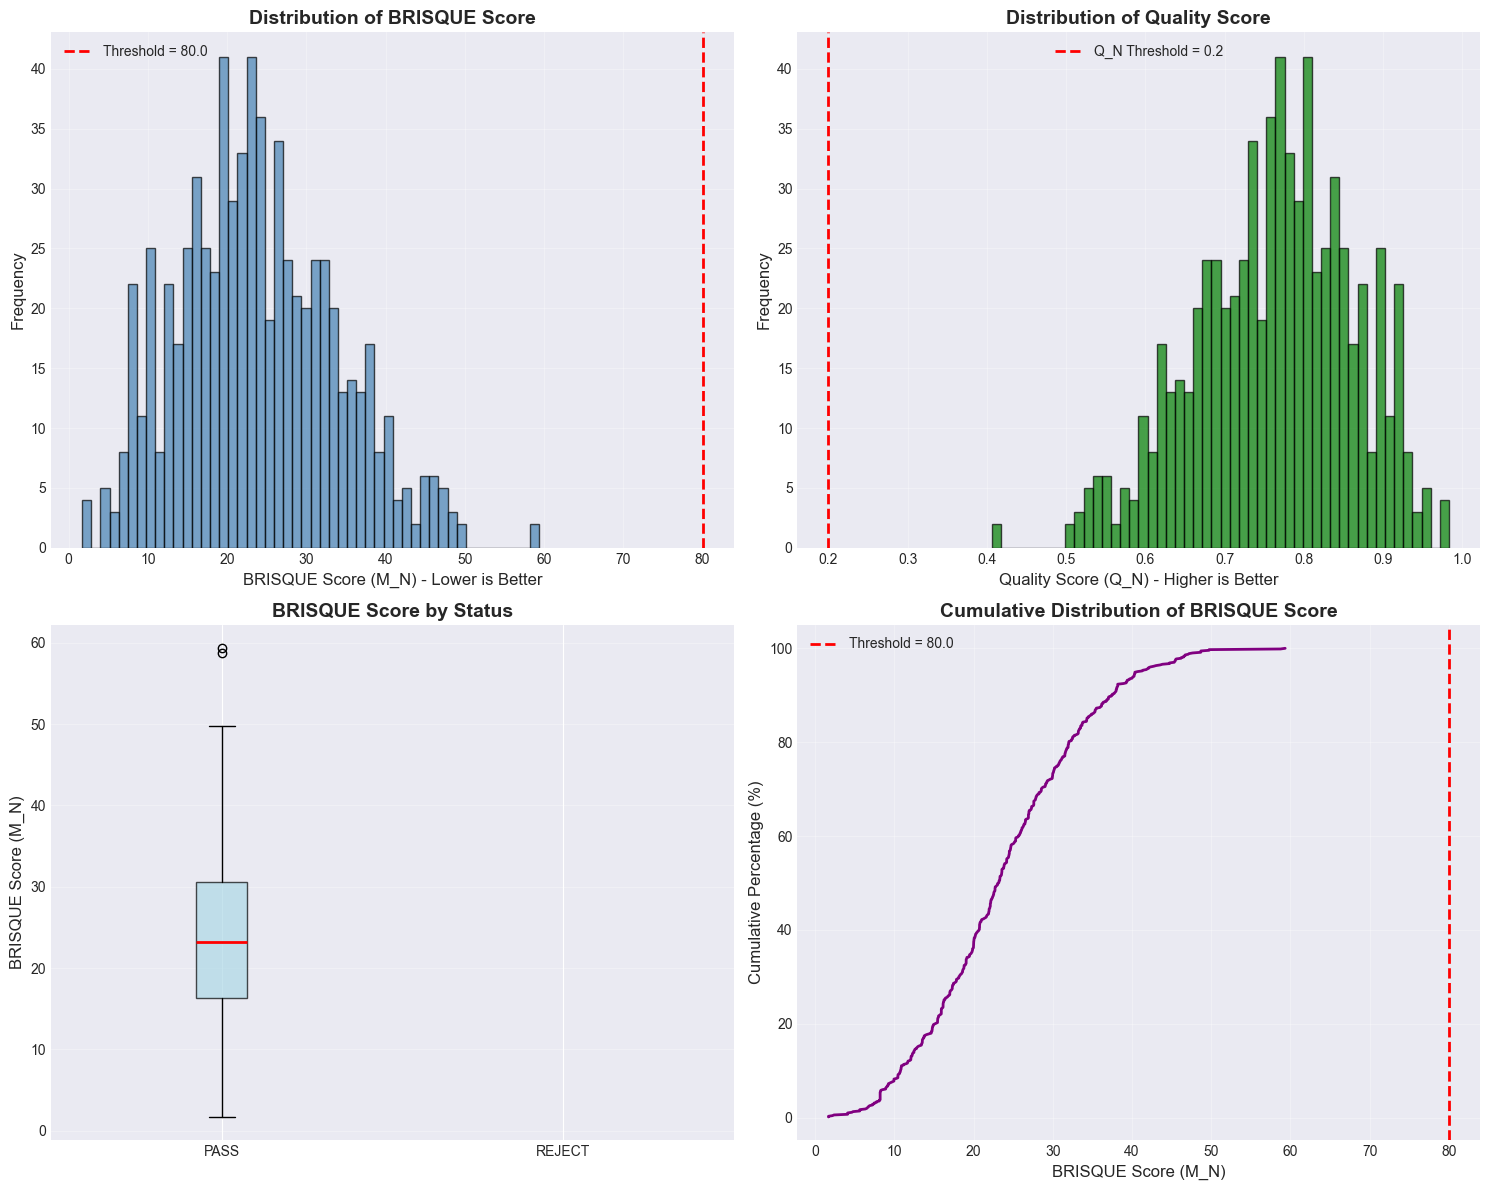


✓ Saved: ..\data\interim\naturalness_distribution.png


In [9]:
if BRISQUE_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Histogram of BRISQUE Score
    ax1 = axes[0, 0]
    ax1.hist(
        df_results["brisque_score"],
        bins=50,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
    )
    ax1.axvline(
        BRISQUE_THRESHOLD,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Threshold = {BRISQUE_THRESHOLD}",
    )
    ax1.set_xlabel("BRISQUE Score (M_N) - Lower is Better", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.set_title("Distribution of BRISQUE Score", fontsize=14, fontweight="bold")
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # 2. Histogram of Quality Score
    ax2 = axes[0, 1]
    ax2.hist(
        df_results["quality_score"],
        bins=50,
        color="green",
        alpha=0.7,
        edgecolor="black",
    )
    ax2.axvline(
        QUALITY_THRESHOLD,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Q_N Threshold = {QUALITY_THRESHOLD}",
    )
    ax2.set_xlabel("Quality Score (Q_N) - Higher is Better", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.set_title("Distribution of Quality Score", fontsize=14, fontweight="bold")
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # 3. Box Plot by Status
    ax3 = axes[1, 0]
    pass_metrics = df_results[df_results["status"] == "PASS"]["brisque_score"]
    reject_metrics = df_results[df_results["status"] == "REJECT"]["brisque_score"]
    ax3.boxplot(
        [pass_metrics, reject_metrics],
        labels=["PASS", "REJECT"],
        patch_artist=True,
        boxprops=dict(facecolor="lightblue", alpha=0.7),
        medianprops=dict(color="red", linewidth=2),
    )
    ax3.set_ylabel("BRISQUE Score (M_N)", fontsize=12)
    ax3.set_title("BRISQUE Score by Status", fontsize=14, fontweight="bold")
    ax3.grid(True, alpha=0.3, axis="y")

    # 4. Cumulative Distribution
    ax4 = axes[1, 1]
    sorted_metrics = np.sort(df_results["brisque_score"])
    cumulative = np.arange(1, len(sorted_metrics) + 1) / len(sorted_metrics) * 100
    ax4.plot(sorted_metrics, cumulative, linewidth=2, color="purple")
    ax4.axvline(
        BRISQUE_THRESHOLD,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Threshold = {BRISQUE_THRESHOLD}",
    )
    ax4.set_xlabel("BRISQUE Score (M_N)", fontsize=12)
    ax4.set_ylabel("Cumulative Percentage (%)", fontsize=12)
    ax4.set_title(
        "Cumulative Distribution of BRISQUE Score", fontsize=14, fontweight="bold"
    )
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        OUTPUT_DIR / "naturalness_distribution.png", dpi=150, bbox_inches="tight"
    )
    plt.show()

    print(f"\n✓ Saved: {OUTPUT_DIR / 'naturalness_distribution.png'}")
else:
    print("Skipping visualization - BRISQUE not available")

## 7. VISUAL COMPARISON: BEST vs WORST QUALITY

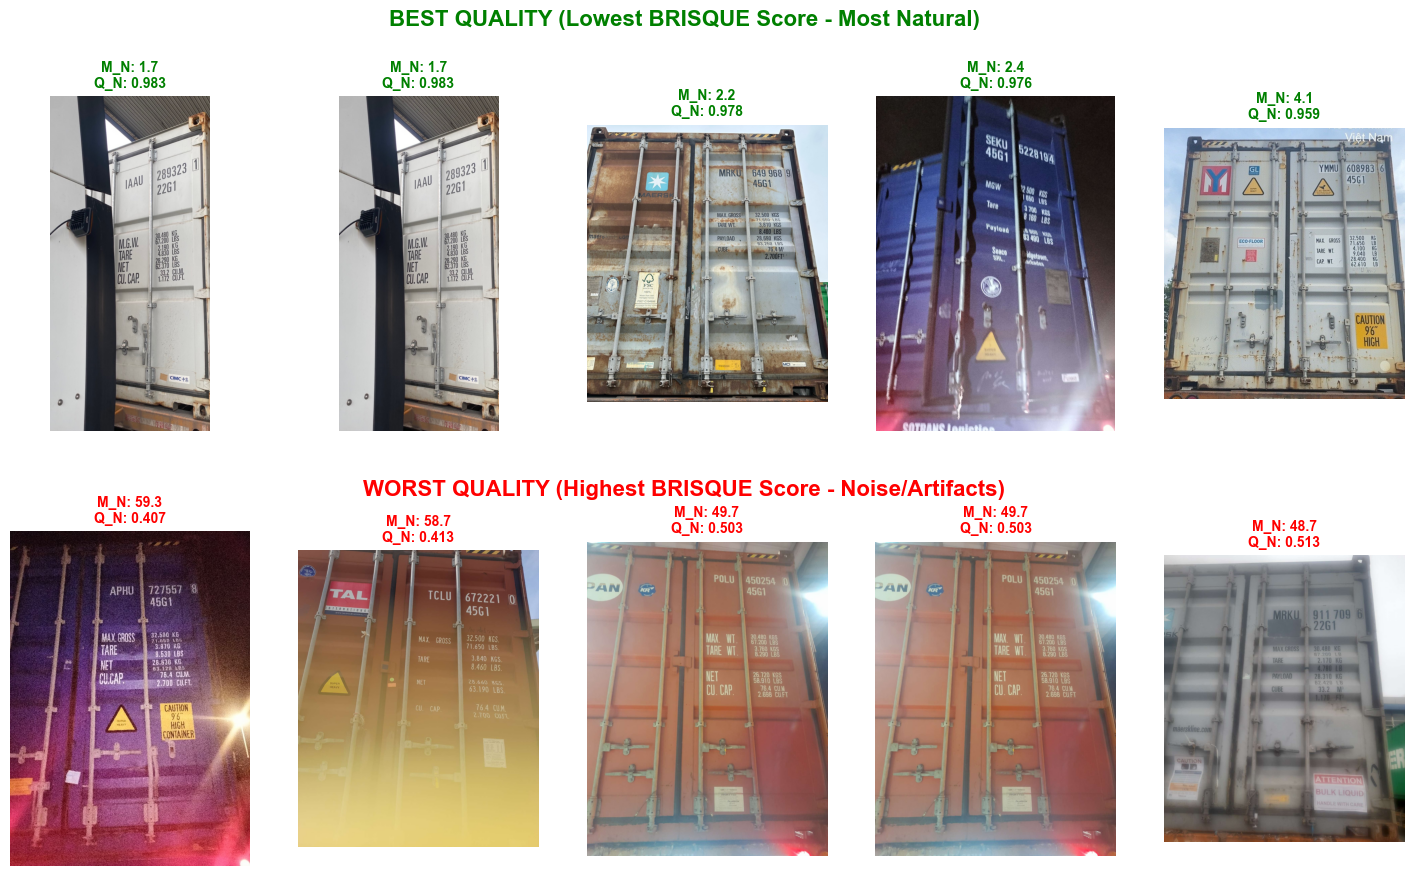


✓ Saved: ..\data\interim\naturalness_comparison.png


In [10]:
if BRISQUE_AVAILABLE:

    def visualize_naturalness_comparison(
        df: pd.DataFrame, roi_dir: Path, n_samples: int = 5
    ):
        """
        Visualize comparison between best and worst quality images.

        Args:
            df: DataFrame with analysis results
            roi_dir: Directory containing ROI images
            n_samples: Number of samples to show for each category
        """
        # Get top N best (lowest BRISQUE) and worst (highest BRISQUE)
        best_quality = df.nsmallest(n_samples, "brisque_score")
        worst_quality = df.nlargest(n_samples, "brisque_score")

        fig = plt.figure(figsize=(18, 10))
        gs = GridSpec(2, n_samples, figure=fig, hspace=0.3, wspace=0.2)

        # Plot best quality images
        fig.text(
            0.5,
            0.95,
            "BEST QUALITY (Lowest BRISQUE Score - Most Natural)",
            ha="center",
            fontsize=16,
            fontweight="bold",
            color="green",
        )

        for i, (idx, row) in enumerate(best_quality.iterrows()):
            img_path = roi_dir / row["filename"]
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax = fig.add_subplot(gs[0, i])
            ax.imshow(img_rgb)
            ax.set_title(
                f"M_N: {row['brisque_score']:.1f}\nQ_N: {row['quality_score']:.3f}",
                fontsize=10,
                color="green",
                fontweight="bold",
            )
            ax.axis("off")

        # Plot worst quality images
        fig.text(
            0.5,
            0.48,
            "WORST QUALITY (Highest BRISQUE Score - Noise/Artifacts)",
            ha="center",
            fontsize=16,
            fontweight="bold",
            color="red",
        )

        for i, (idx, row) in enumerate(worst_quality.iterrows()):
            img_path = roi_dir / row["filename"]
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax = fig.add_subplot(gs[1, i])
            ax.imshow(img_rgb)
            ax.set_title(
                f"M_N: {row['brisque_score']:.1f}\nQ_N: {row['quality_score']:.3f}",
                fontsize=10,
                color="red",
                fontweight="bold",
            )
            ax.axis("off")

        plt.savefig(
            OUTPUT_DIR / "naturalness_comparison.png", dpi=150, bbox_inches="tight"
        )
        plt.show()
        print(f"\n✓ Saved: {OUTPUT_DIR / 'naturalness_comparison.png'}")

    # Run visualization
    visualize_naturalness_comparison(df_results, ROI_DIR, n_samples=5)
else:
    print("Skipping comparison - BRISQUE not available")

## 8. THRESHOLD CALIBRATION ANALYSIS

In [11]:
if BRISQUE_AVAILABLE:
    # Test different BRISQUE threshold values
    threshold_candidates = [50, 60, 70, 80, 90, 100]
    calibration_results = []

    for threshold in threshold_candidates:
        df_temp = df_results.copy()
        # Q_N = 1.0 - M_N/100
        # Q_N < 0.2 means REJECT
        # So M_N > 80 means REJECT
        df_temp["pass_temp"] = df_temp["brisque_score"] <= threshold

        pass_count = df_temp["pass_temp"].sum()
        pass_rate = pass_count / len(df_temp) * 100

        calibration_results.append(
            {
                "threshold": threshold,
                "pass_count": pass_count,
                "pass_rate": pass_rate,
                "reject_count": len(df_temp) - pass_count,
            }
        )

    df_calibration = pd.DataFrame(calibration_results)
    print("\n" + "=" * 60)
    print("THRESHOLD CALIBRATION ANALYSIS")
    print("=" * 60)
    print(df_calibration.to_string(index=False))
    print("=" * 60)
else:
    print("Skipping calibration - BRISQUE not available")


THRESHOLD CALIBRATION ANALYSIS
 threshold  pass_count  pass_rate  reject_count
        50         704  99.716714             2
        60         706 100.000000             0
        70         706 100.000000             0
        80         706 100.000000             0
        90         706 100.000000             0
       100         706 100.000000             0


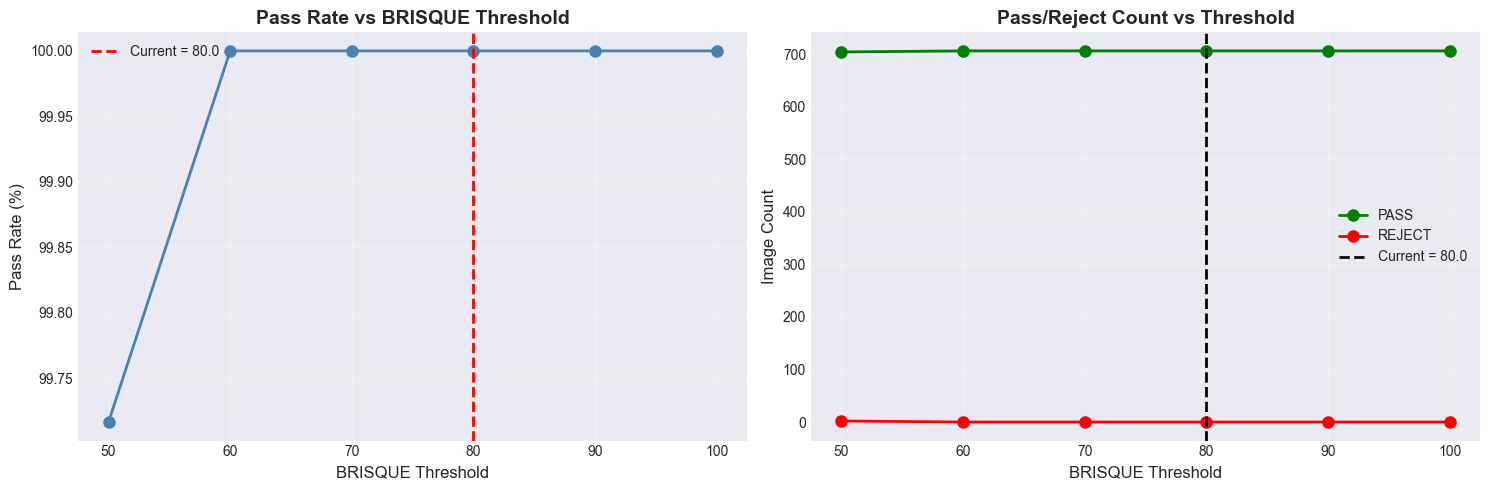


✓ Saved: ..\data\interim\brisque_threshold_calibration.png


In [12]:
if BRISQUE_AVAILABLE:
    # Visualize calibration results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Pass rate vs threshold
    ax1.plot(
        df_calibration["threshold"],
        df_calibration["pass_rate"],
        marker="o",
        linewidth=2,
        markersize=8,
        color="steelblue",
    )
    ax1.axvline(
        BRISQUE_THRESHOLD,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Current = {BRISQUE_THRESHOLD}",
    )
    ax1.set_xlabel("BRISQUE Threshold", fontsize=12)
    ax1.set_ylabel("Pass Rate (%)", fontsize=12)
    ax1.set_title("Pass Rate vs BRISQUE Threshold", fontsize=14, fontweight="bold")
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)

    # Image count by status
    ax2.plot(
        df_calibration["threshold"],
        df_calibration["pass_count"],
        marker="o",
        linewidth=2,
        markersize=8,
        label="PASS",
        color="green",
    )
    ax2.plot(
        df_calibration["threshold"],
        df_calibration["reject_count"],
        marker="o",
        linewidth=2,
        markersize=8,
        label="REJECT",
        color="red",
    )
    ax2.axvline(
        BRISQUE_THRESHOLD,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Current = {BRISQUE_THRESHOLD}",
    )
    ax2.set_xlabel("BRISQUE Threshold", fontsize=12)
    ax2.set_ylabel("Image Count", fontsize=12)
    ax2.set_title("Pass/Reject Count vs Threshold", fontsize=14, fontweight="bold")
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(
        OUTPUT_DIR / "brisque_threshold_calibration.png", dpi=150, bbox_inches="tight"
    )
    plt.show()

    print(f"\n✓ Saved: {OUTPUT_DIR / 'brisque_threshold_calibration.png'}")
else:
    print("Skipping threshold calibration visualization - BRISQUE not available")

## 9. OUTLIER ANALYSIS: EXTREME CASES

In [13]:
if BRISQUE_AVAILABLE:
    # Find extreme outliers (very high BRISQUE scores)
    q75 = df_results["brisque_score"].quantile(0.75)
    q95 = df_results["brisque_score"].quantile(0.95)

    print(f"\nBRISQUE Score Percentiles:")
    print(f"  P75 (75th percentile): {q75:.2f}")
    print(f"  P95 (95th percentile): {q95:.2f}")

    outliers = df_results[df_results["brisque_score"] > q95].sort_values(
        "brisque_score", ascending=False
    )

    print(f"\nOutliers (BRISQUE > P95 = {q95:.2f}):")
    print(f"Total: {len(outliers)}")
    if len(outliers) > 0:
        print(
            outliers[["filename", "brisque_score", "quality_score", "status"]]
            .head(10)
            .to_string(index=False)
        )
else:
    print("Skipping outlier analysis - BRISQUE not available")


BRISQUE Score Percentiles:
  P75 (75th percentile): 30.64
  P95 (95th percentile): 40.63

Outliers (BRISQUE > P95 = 40.63):
Total: 36
   filename  brisque_score  quality_score status
0018817.jpg      59.330738       0.406693   PASS
0035157.jpg      58.739120       0.412609   PASS
0003380.jpg      49.723045       0.502770   PASS
0021605.jpg      49.723045       0.502770   PASS
0026565.jpg      48.682667       0.513173   PASS
0015435.jpg      48.682667       0.513173   PASS
0013073.jpg      48.679214       0.513208   PASS
0028978.jpg      47.647186       0.523528   PASS
0039113.jpg      47.195904       0.528041   PASS
0008913.jpg      47.079304       0.529207   PASS


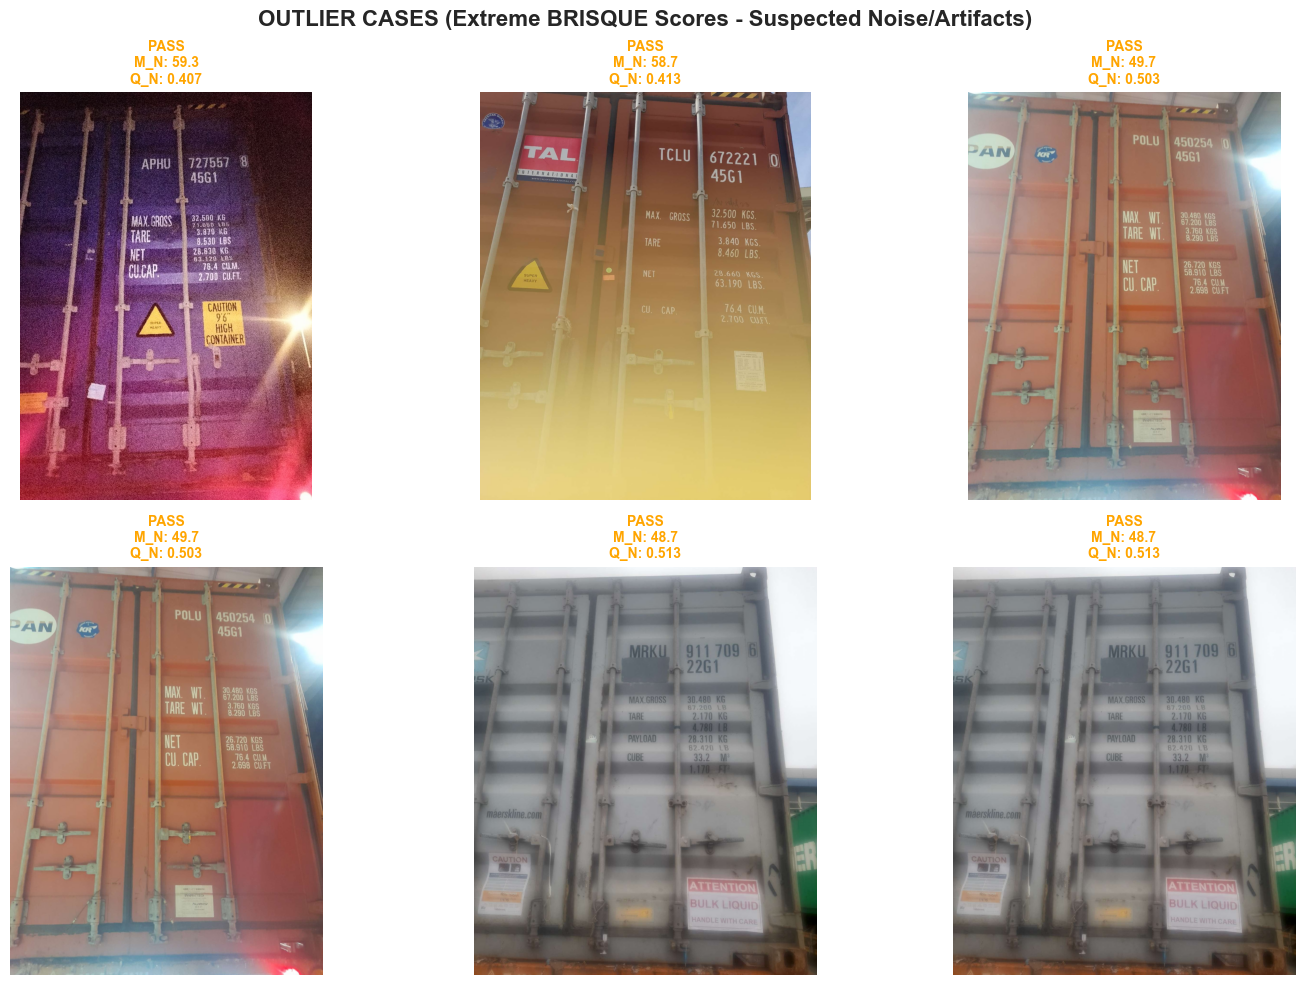


✓ Saved: ..\data\interim\brisque_outliers.png


In [14]:
if BRISQUE_AVAILABLE and len(outliers) > 0:
    # Visualize outlier cases
    n_show = min(6, len(outliers))
    sample_outliers = outliers.head(n_show)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    fig.suptitle(
        "OUTLIER CASES (Extreme BRISQUE Scores - Suspected Noise/Artifacts)",
        fontsize=16,
        fontweight="bold",
    )

    for i, (idx, row) in enumerate(sample_outliers.iterrows()):
        if i >= n_show:
            break

        img_path = ROI_DIR / row["filename"]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        color = "red" if row["status"] == "REJECT" else "orange"

        axes[i].imshow(img_rgb)
        axes[i].set_title(
            f"{row['status']}\n"
            f"M_N: {row['brisque_score']:.1f}\n"
            f"Q_N: {row['quality_score']:.3f}",
            fontsize=10,
            color=color,
            fontweight="bold",
        )
        axes[i].axis("off")

    # Hide unused subplots
    for i in range(len(sample_outliers), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "brisque_outliers.png", dpi=150, bbox_inches="tight")
    plt.show()
    print(f"\n✓ Saved: {OUTPUT_DIR / 'brisque_outliers.png'}")
else:
    if BRISQUE_AVAILABLE:
        print("No outliers to visualize.")
    else:
        print("Skipping outlier visualization - BRISQUE not available")

## 10. SAVE RESULTS

In [15]:
if BRISQUE_AVAILABLE:
    # Save detailed report
    output_file = OUTPUT_DIR / "naturalness_check_report.csv"
    df_results.to_csv(output_file, index=False)
    print(f"\n✓ Saved: {output_file}")
    print(f"  Total records: {len(df_results)}")

    # Save summary statistics
    summary = {
        "total_images": len(df_results),
        "pass_count": (df_results["status"] == "PASS").sum(),
        "reject_count": (df_results["status"] == "REJECT").sum(),
        "pass_rate": (df_results["status"] == "PASS").sum() / len(df_results) * 100,
        "threshold_used": BRISQUE_THRESHOLD,
        "quality_threshold": QUALITY_THRESHOLD,
        "metric_mean": df_results["brisque_score"].mean(),
        "metric_median": df_results["brisque_score"].median(),
        "metric_std": df_results["brisque_score"].std(),
        "metric_min": df_results["brisque_score"].min(),
        "metric_max": df_results["brisque_score"].max(),
    }

    summary_file = OUTPUT_DIR / "naturalness_summary.txt"
    with open(summary_file, "w") as f:
        f.write("NATURALNESS ANALYSIS SUMMARY (BRISQUE)\n")
        f.write("=" * 50 + "\n\n")
        for key, value in summary.items():
            f.write(f"{key}: {value}\n")

    print(f"✓ Saved: {summary_file}")
else:
    print("Skipping result saving - BRISQUE not available")


✓ Saved: ..\data\interim\naturalness_check_report.csv
  Total records: 706
✓ Saved: ..\data\interim\naturalness_summary.txt


## 11. CONCLUSIONS & RECOMMENDATIONS

In [16]:
if BRISQUE_AVAILABLE:
    print("\n" + "=" * 60)
    print("TASK 4: NATURALNESS ANALYSIS - CONCLUSIONS")
    print("=" * 60)
    print(f"\n1. CURRENT CONFIGURATION:")
    print(f"   - BRISQUE Threshold: {BRISQUE_THRESHOLD}")
    print(f"   - Quality Threshold (Q_N): {QUALITY_THRESHOLD}")
    print(
        f"   - Effective M_N cutoff: {BRISQUE_THRESHOLD} (scores above this are rejected)"
    )

    print(f"\n2. RESULTS:")
    print(f"   - Total Images: {len(df_results)}")
    print(
        f"   - PASS: {(df_results['status'] == 'PASS').sum()} ({(df_results['status'] == 'PASS').sum()/len(df_results)*100:.2f}%)"
    )
    print(
        f"   - REJECT: {(df_results['status'] == 'REJECT').sum()} ({(df_results['status'] == 'REJECT').sum()/len(df_results)*100:.2f}%)"
    )

    print(f"\n3. METRIC STATISTICS:")
    print(f"   - Mean BRISQUE: {df_results['brisque_score'].mean():.2f}")
    print(f"   - Median BRISQUE: {df_results['brisque_score'].median():.2f}")
    print(f"   - Std Dev: {df_results['brisque_score'].std():.2f}")
    print(
        f"   - Range: [{df_results['brisque_score'].min():.2f}, {df_results['brisque_score'].max():.2f}]"
    )

    print(f"\n4. RECOMMENDATIONS:")
    if df_results["brisque_score"].median() > BRISQUE_THRESHOLD:
        print(f"   ⚠️  Median BRISQUE is above threshold.")
        print(f"   → Consider raising threshold or improving data quality.")
    else:
        print(f"   ✓ Median BRISQUE is below threshold - good quality overall.")

    reject_rate = (df_results["status"] == "REJECT").sum() / len(df_results) * 100
    if reject_rate > 30:
        print(f"   ⚠️  High rejection rate ({reject_rate:.1f}%)")
        print(f"   → Review rejected images and consider threshold adjustment.")
    elif reject_rate < 5:
        print(f"   ⚠️  Very low rejection rate ({reject_rate:.1f}%)")
        print(f"   → Threshold might be too lenient.")
    else:
        print(f"   ✓ Rejection rate ({reject_rate:.1f}%) is reasonable.")

    print(f"\n5. NEXT STEPS:")
    print(f"   - Review visualizations to validate threshold choice")
    print(f"   - Examine outlier cases for severe artifacts")
    print(f"   - Proceed to Task 5: Pipeline Integration")
    print("=" * 60)
else:
    print("\n" + "=" * 60)
    print("⚠️  OPENCV BRISQUE NOT AVAILABLE")
    print("=" * 60)
    print("To complete Task 4, please:")
    print("1. Remove opencv-python: uv remove opencv-python")
    print("2. Install opencv-contrib-python: uv add opencv-contrib-python")
    print("3. Restart the kernel")
    print("4. Re-run all cells")
    print("=" * 60)


TASK 4: NATURALNESS ANALYSIS - CONCLUSIONS

1. CURRENT CONFIGURATION:
   - BRISQUE Threshold: 80.0
   - Quality Threshold (Q_N): 0.2
   - Effective M_N cutoff: 80.0 (scores above this are rejected)

2. RESULTS:
   - Total Images: 706
   - PASS: 706 (100.00%)
   - REJECT: 0 (0.00%)

3. METRIC STATISTICS:
   - Mean BRISQUE: 23.80
   - Median BRISQUE: 23.19
   - Std Dev: 10.00
   - Range: [1.69, 59.33]

4. RECOMMENDATIONS:
   ✓ Median BRISQUE is below threshold - good quality overall.
   ⚠️  Very low rejection rate (0.0%)
   → Threshold might be too lenient.

5. NEXT STEPS:
   - Review visualizations to validate threshold choice
   - Examine outlier cases for severe artifacts
   - Proceed to Task 5: Pipeline Integration
